# 批量归一化
- 损失出现在最后，后面的层训练较快
- 数据在最底部
    - 底部的层训练较慢
    - 底部层一变化，所有的得跟着变
    - 最后的那些层需要重新学习多次
    - 导致收敛变慢
- 是否可以在学习底部层的时候避免变化顶部层？

#### 固定小批量里面的均值和方差
- 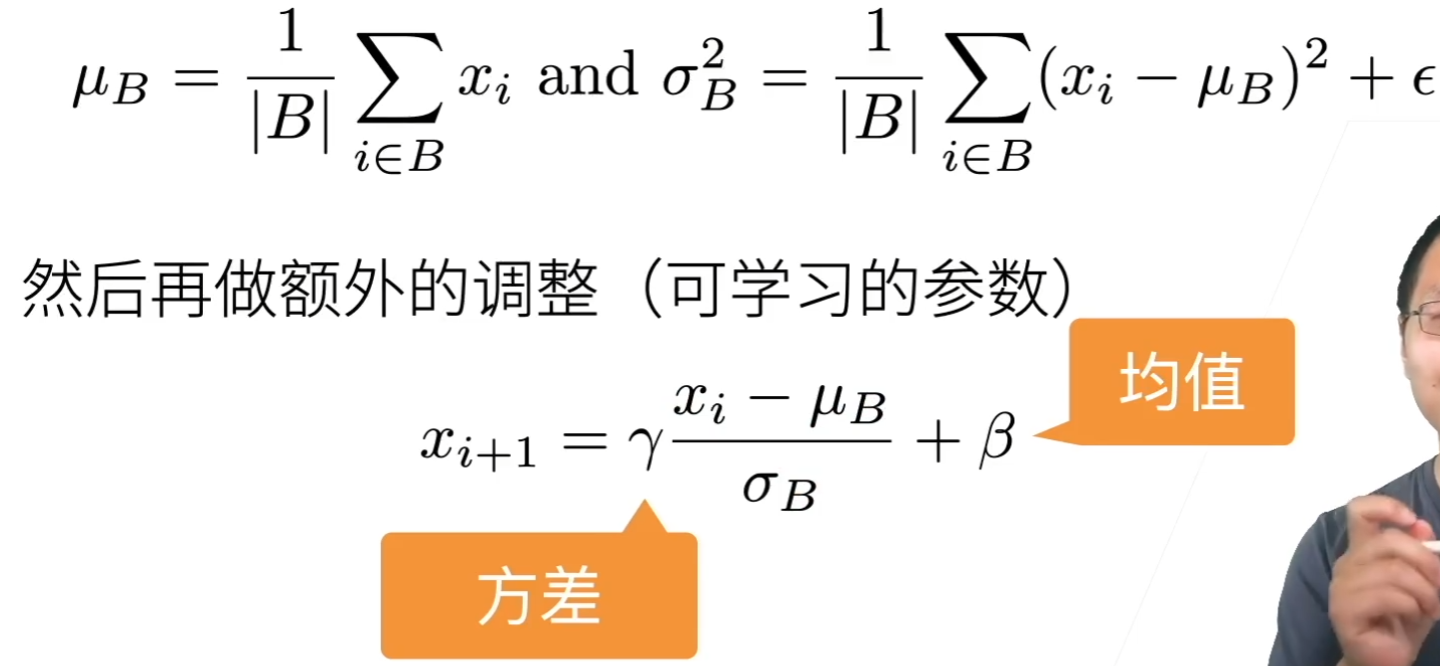
- 其中参数beta gama可以学习，而不是标准的正态分布
- 作用在
    - 全连接层和卷积层输出上，激活函数前（如果放在relu后面，relu已经都全部变为正再拉回去，显得太奇怪），就是个线性变化使得不同层间数据变化不要太大
    - 全连接层和卷积层输入上
- 对于全连接层，作用在特征维
    - 对2d来说，对特征算一个标量的均值和方差（在数据预处理经常干均值0，方差1处理，在这里就是对每个全连接做这个，而不是只是数据上，而且不一定是0 1，而是参数的beta gama对数据做调教）
- 对于卷积层，作用在通道维
    - 这里可以类比1x1卷积作用在4d(batch,channel, h, w),此时做1x1相当于把（0， 2， 3）三个拉成一个作为样本集batch，然后通道维作为一个样本特征，然后1x1就是从里面做全连接抽取特征
    - BN也是类似，在通道维上算均值方差然后做运算，就是最后的结果是一个通道的均值和方差，如4d conv(batch_size, channel, h, w)做完（1, channel, 1, 1）

#### BN在干什么？
- 最初论文是想用来减少内部协变量转移
- 后续论文指出它可能就是通过在每个小批量里加入噪音来控制模型复杂度
    - 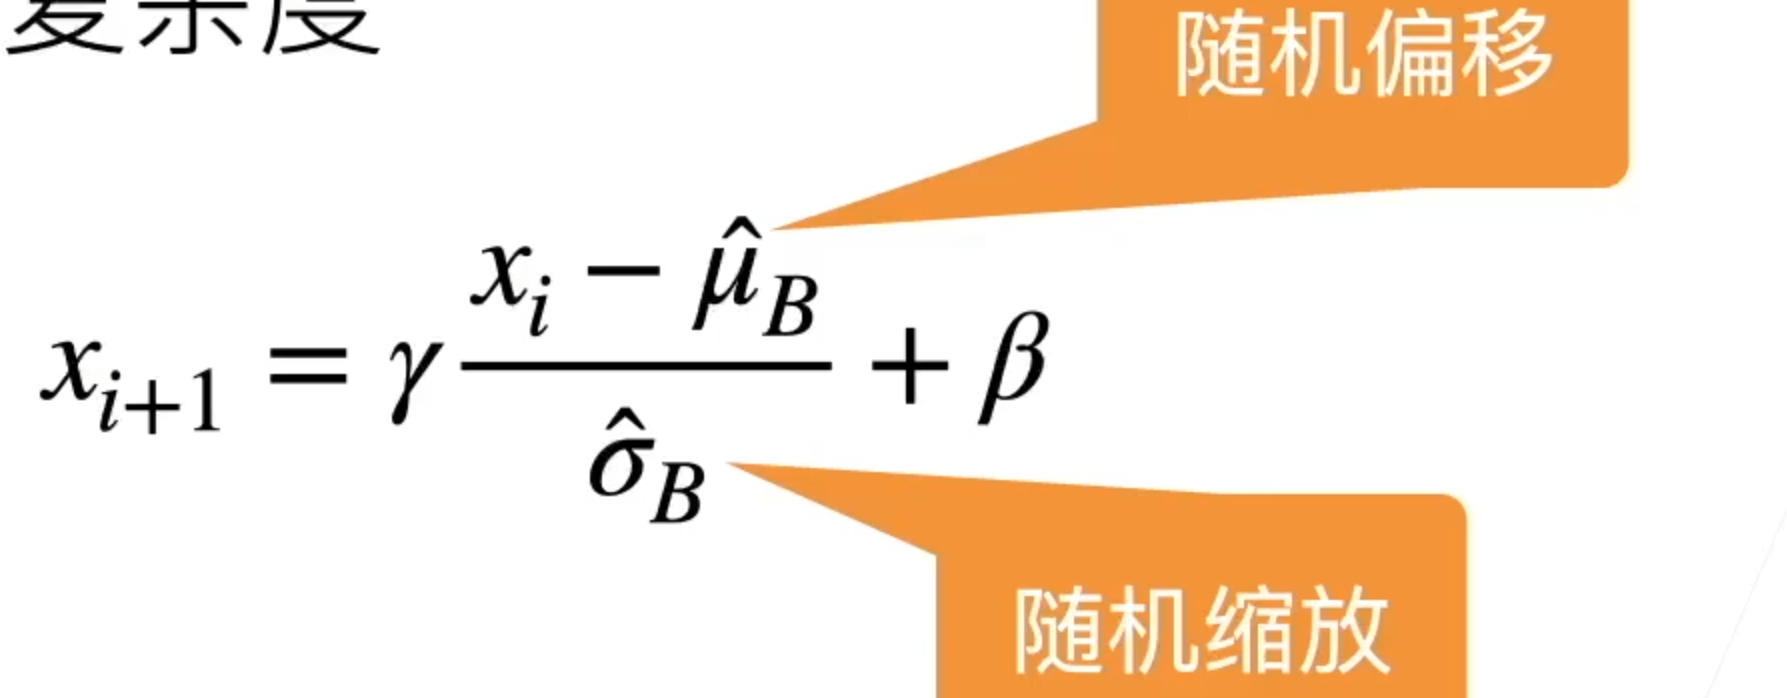
    - 相当于先随机加入了一个偏移和缩放，然后又通过学到的均值和方差来使得变化没那么剧烈，同时又有一定随机性
- 因此没变要跟dropout（也是为了控制模型复杂度）混合使用，只要2选1即可
- 但是上述理论也不一定对，只是work而已，当前DL工程走在理论前面

#### 总结
- BN固定小批量中的均值和方差，然后学习出适合的偏移和缩放
- 可以加速收敛速度，一般不会改变模型精度

## BN代码从0实现

In [2]:
import torch 
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 这里的eps很关键，防止除0翻车
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            mean = X.mean(dim=0)
            var = ((X - mean)**2).mean(dim=0)
        else:
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + eps)
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean, moving_var

In [13]:
# 创建一个正确的BatchNorm图层
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
        
    def forward(self, X):
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, 
            self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
        # eps不同框架选择不同，一般1e-5
        
        return Y

In [14]:
# 应用BatchNorm与LeNet模型
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
    BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
    nn.Sigmoid(), nn.Linear(84,10))

loss 0.247, train acc 0.909, test acc 0.866
19892.8 examples/sec on cuda


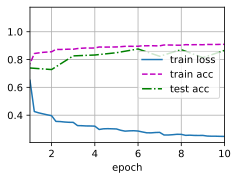

In [15]:
# 在Fashion-Mnist上的训练
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device='cuda')

In [18]:
# 查看下gamam和beta
net[5].gamma.reshape((-1,)), net[5].beta.reshape((-1,))

(tensor([1.0499, 1.2639, 1.1191, 1.1668, 1.1012, 1.0862, 1.3135, 1.0004, 2.0256,
         0.8003, 1.0467, 1.8073, 0.9248, 1.0671, 1.2130, 1.1636],
        device='cuda:0', grad_fn=<ReshapeAliasBackward0>),
 tensor([-0.5009, -0.5728, -0.2531, -1.0604, -0.2811, -0.2755, -0.0494, -0.4142,
          0.9418, -0.8632, -0.3965, -0.5422, -0.5740,  0.2875,  0.0260, -0.4961],
        device='cuda:0', grad_fn=<ReshapeAliasBackward0>))

In [20]:
# 简明实现
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(16 * 4 * 4, 120),
    BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84),
    nn.Sigmoid(), nn.Linear(84,10))

loss 0.223, train acc 0.918, test acc 0.884
15915.2 examples/sec on cuda


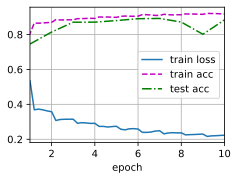

In [24]:
lr, num_epochs, batch_size = 1.0, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device='cuda')

## BN QA
#### 跟之前讲的xavier区别是什么呢？
- 其实本质没区别，核心思路都是一致的，都是为了模型训练的稳定，xaier是在训练开始时进行初始化核心数值稳定，而BN是在过程中对某个层做操作，加速训练

#### 浅层MLP效果好像一般？
- 对的，一般浅层不太会出现后面学习快，前面难以学习的情况，相对效果不明显

#### BN是线性变换？那跟直接加一个线性层有什么区别呢？
- 没啥区别，但是加一个层不会直接学习到想要的参数，不做的话很有可能数值不稳定

#### BN为什么会加速收敛？
- 本质是可以使用更大学习率，使得权重变快更新

#### epochs batch_size 学习率 框架怎么设置呢？
- 一般来说epoch可以调大点，无非浪费训练资源，然后调个好的batch_size不能太大也不能太小，根据内存调节batch_size,然后调节学习率，效果好停掉epochs即可

#### Pytorch 中的layernorm 跟BN区别？
- xx norm有很多，核心思想就是找几个维度做normlizaion，layer norm是有时候4k图无法做bn时候用的

#### batch size 是把显存占满好还是 gpu利用率100%就可以了？还是需要同时？
- 一般利用率90+就可以了，不要100%，调节batch_size查看每秒处理的样本数，如果发现没有明显增加就可以停掉了
- 要主要batch size太大收敛可能会有问题，如Lenet可以调1k多但是收敛会有问题